In [1]:
# # Behavioral Anomaly Detection – Getting Started

# This notebook is an **interactive walkthrough** of the Insider Threat Detection system.

# ### Purpose
# - Understand the CERT dataset
# - Engineer behavioral features
# - Build statistical baselines
# - Detect anomalies
# - Explain results (WHY something is flagged)

# ⚠️ This notebook is for **learning, validation, and demonstration**  
# Production runs are done via `train.py` and `inference.py`.

import sys
sys.modules.pop("data_loader", None)



In [12]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Make src/ visible to notebook
import sys
sys.path.append("../src")

# Import project modules
from data_loader import CERTDataLoader
from feature_engineering import BehavioralFeatureEngineer
from distribution_builder import DistributionBuilder
from anomaly_scorer import AnomalyScorer
from visualizer import BehavioralVisualizer

# Plot settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ Environment setup complete")


✅ Environment setup complete


In [13]:
DATA_DIR = "../data/raw"

loader = CERTDataLoader(DATA_DIR)
raw_data = loader.load_all()

display(loader.get_data_summary())

min_date, max_date = loader.get_date_range()
print(f"Date Range: {min_date} → {max_date}")
print(f"Total Users: {len(loader.get_user_list())}")


,source,rows,columns
0,email,2629979,"[id, date, user, pc, to, cc, bcc, from, size, ..."
1,psychometric,1000,"[employee_name, user, openness, conscientiousn..."


Date Range: 2010-01-02 07:11:45 → 2011-05-16 21:16:26
Total Users: 1000


In [14]:
engineer = BehavioralFeatureEngineer(aggregation_window="1D")

features = engineer.create_unified_feature_matrix(raw_data)

print("✅ Features created")
print(features.shape)
features.head()


✅ Features created
(326985, 14)


,user,date_only,email_sent_count,unique_recipients_count,external_recipient_ratio,after_hours_email_count,avg_email_size_kb,openness,conscientiousness,extraversion,agreeableness,neuroticism,day_of_week,is_weekend
0,AAE0190,2010-01-04,14,24,1.0,0,30.784598,0.265645,-0.057831,-1.387034,1.895918,-0.123114,0,0
1,AAE0190,2010-01-05,13,24,1.0,0,26.709135,0.265645,-0.057831,-1.387034,1.895918,-0.123114,1,0
2,AAE0190,2010-01-06,14,21,1.0,0,37.154506,0.265645,-0.057831,-1.387034,1.895918,-0.123114,2,0
3,AAE0190,2010-01-07,14,21,1.0,0,33.107631,0.265645,-0.057831,-1.387034,1.895918,-0.123114,3,0
4,AAE0190,2010-01-08,13,21,1.0,0,30.095928,0.265645,-0.057831,-1.387034,1.895918,-0.123114,4,0


In [15]:
import sys
sys.path.append("../src")

from data_loader import CERTDataLoader


In [16]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libs
import pandas as pd
import numpy as np

# Make src visible
import sys
sys.path.append("../src")

# Import loader
from data_loader import CERTDataLoader

print("✅ CERTDataLoader imported successfully")


✅ CERTDataLoader imported successfully


In [17]:
import pandas as pd

df = pd.read_csv("../data/raw/psychometric.csv")
print(df.columns.tolist())


['employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N']


In [18]:
email_df = raw_data["email"]

display(email_df.head())

print("\nEmail activity sample:")
print(email_df[["user", "date", "recipient_count", "size_kb"]].head())


,id,date,user,pc,to,cc,bcc,from,size,attachments,content,recipient_count,has_external_recipient,size_kb,hour,day_of_week,is_weekend,is_after_hours
0,{R3I7-S4TX96FG-8219JWFF},2010-01-02 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,2,1,25.224609,7,5,1,0
1,{R0R9-E4GL59IK-2907OSWJ},2010-01-02 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,1,1,29.240234,7,5,1,0
2,{G2B2-A8XY58CP-2847ZJZL},2010-01-02 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,1,1,28.105469,7,5,1,0
3,{A3A9-F4TH89AA-8318GFGK},2010-01-02 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,1,1,21.393555,7,5,1,0
4,{E8B7-C8FZ88UF-2946RUQQ},2010-01-02 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,3,1,16.913086,7,5,1,0



Email activity sample:
      user                date  recipient_count    size_kb
0  LAP0338 2010-01-02 07:11:45                2  25.224609
1  MOH0273 2010-01-02 07:12:16                1  29.240234
2  LAP0338 2010-01-02 07:13:00                1  28.105469
3  LAP0338 2010-01-02 07:13:17                1  21.393555
4  MOH0273 2010-01-02 07:13:28                3  16.913086


In [19]:
engineer = BehavioralFeatureEngineer(aggregation_window="1D")
features = engineer.create_unified_feature_matrix(raw_data)

print(f"Feature matrix shape: {features.shape}")
display(features.head())


Feature matrix shape: (326985, 14)


,user,date_only,email_sent_count,unique_recipients_count,external_recipient_ratio,after_hours_email_count,avg_email_size_kb,openness,conscientiousness,extraversion,agreeableness,neuroticism,day_of_week,is_weekend
0,AAE0190,2010-01-04,14,24,1.0,0,30.784598,0.265645,-0.057831,-1.387034,1.895918,-0.123114,0,0
1,AAE0190,2010-01-05,13,24,1.0,0,26.709135,0.265645,-0.057831,-1.387034,1.895918,-0.123114,1,0
2,AAE0190,2010-01-06,14,21,1.0,0,37.154506,0.265645,-0.057831,-1.387034,1.895918,-0.123114,2,0
3,AAE0190,2010-01-07,14,21,1.0,0,33.107631,0.265645,-0.057831,-1.387034,1.895918,-0.123114,3,0
4,AAE0190,2010-01-08,13,21,1.0,0,30.095928,0.265645,-0.057831,-1.387034,1.895918,-0.123114,4,0


In [23]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make src/ visible
import sys
sys.path.append("../src")

# Import project modules
from data_loader import CERTDataLoader
from feature_engineering import BehavioralFeatureEngineer
from distribution_builder import DistributionBuilder
from anomaly_scorer import AnomalyScorer
from visualizer import BehavioralVisualizer

# Plot settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ Environment setup complete")


✅ Environment setup complete


In [24]:
# Sort by time
features = features.sort_values("date_only")

# Train / test split
split_idx = int(len(features) * 0.7)
train_features = features.iloc[:split_idx]
test_features = features.iloc[split_idx:]

builder = DistributionBuilder(min_observations=10)

print("Building personal distributions...")
builder.build_personal_distributions(train_features)

print("Building temporal distributions...")
builder.build_temporal_distributions(train_features)

print("✅ Distributions built")


Building personal distributions...
Building temporal distributions...
✅ Distributions built


In [26]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libs
import pandas as pd
import numpy as np

# Make src visible
import sys
sys.path.append("../src")

# ✅ IMPORT THE CLASS
from distribution_builder import DistributionBuilder

print("✅ DistributionBuilder imported successfully")


✅ DistributionBuilder imported successfully


In [27]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import sys
sys.path.append("../src")

from data_loader import CERTDataLoader
from feature_engineering import BehavioralFeatureEngineer
from distribution_builder import DistributionBuilder
from anomaly_scorer import AnomalyScorer

print("✅ Imports successful")


✅ Imports successful


In [28]:
# Load data
loader = CERTDataLoader("../data/raw")
raw_data = loader.load_all()

# Feature engineering
engineer = BehavioralFeatureEngineer("1D")
features = engineer.create_unified_feature_matrix(raw_data)

# Train / test split
features = features.sort_values("date_only")
split_idx = int(len(features) * 0.7)
train_features = features.iloc[:split_idx]
test_features = features.iloc[split_idx:]

# Build distributions
builder = DistributionBuilder(min_observations=10)
builder.build_personal_distributions(train_features)
builder.build_temporal_distributions(train_features)

print("✅ Distributions built")


✅ Distributions built


In [30]:
scorer = AnomalyScorer(builder)

results = scorer.score_dataframe(test_features.head(500))

display(results.head())

print("\nSeverity distribution:")
print(results["severity"].value_counts())


,user,date,anomaly_score,severity,flagged_count,top_feature,explanation
0,AHM0410,2010-12-06,0.573132,MEDIUM,0,None,No significant behavioral deviations detected.
1,CAA0612,2010-12-06,0.635452,MEDIUM,1,unique_recipients_count,unique_recipients_count is rare for this day (...
2,SKG0759,2010-12-06,0.581646,MEDIUM,0,None,No significant behavioral deviations detected.
3,PLH0715,2010-12-06,0.591134,MEDIUM,0,None,No significant behavioral deviations detected.
4,SJW0451,2010-12-06,0.561070,MEDIUM,0,None,No significant behavioral deviations detected.



Severity distribution:
severity
MEDIUM    499
LOW         1
Name: count, dtype: int64


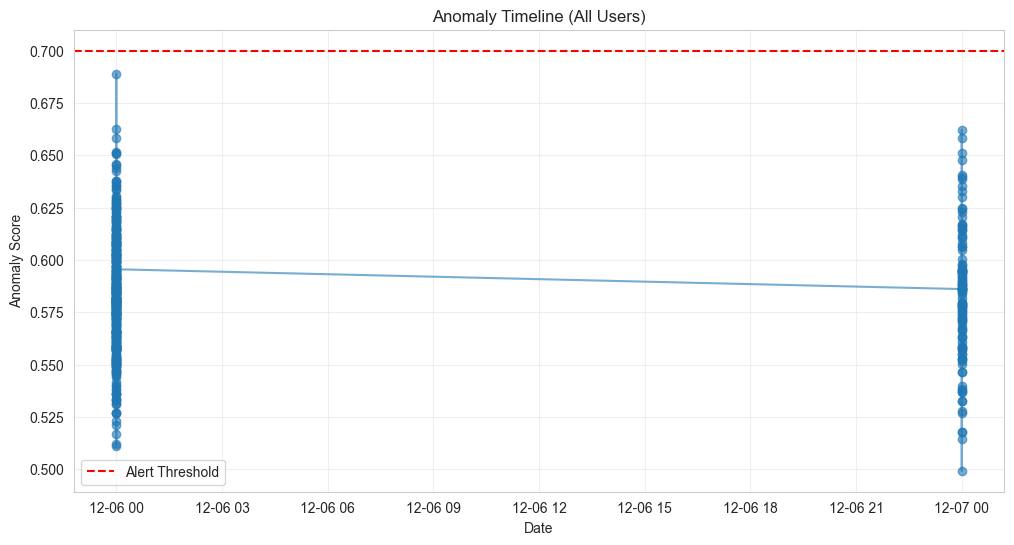

In [31]:
viz = BehavioralVisualizer(builder)

viz.plot_anomaly_timeline(results)


In [32]:
# Always restart kernel before this
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")

from data_loader import CERTDataLoader
from feature_engineering import BehavioralFeatureEngineer
from distribution_builder import DistributionBuilder
from anomaly_scorer import AnomalyScorer
from visualizer import BehavioralVisualizer   # ✅ REQUIRED

print("✅ All modules imported successfully")


✅ All modules imported successfully


In [33]:
# Save models and results
builder.save("../models/distributions/baseline_distributions.pkl")
results.to_csv("../results/anomaly_scores.csv", index=False)

print("✅ Models and results saved")


✅ Models and results saved


In [37]:
import os

# Use the notebook's DATA_DIR variable (fallback to an absolute path if it's not defined)
try:
	file_path = os.path.join(DATA_DIR, "email.csv")
except NameError:
	file_path = r"D:/vs/VScode/insider_threat_detection/data/raw/email.csv"

# Don't overwrite the existing `df` — load into a new variable
email_df_local = pd.read_csv(file_path)
print(email_df_local.columns.tolist())


['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size', 'attachments', 'content']


In [38]:
import pandas as pd
df = pd.read_csv("data/raw/psychometric.csv")
print(df.columns)


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/psychometric.csv'

In [9]:
from src.data_loader import CERTDataLoader

loader = CERTDataLoader("data/raw")
data = loader.load_all()

print(data["psychometric"].columns.tolist())


['employee_name', 'user', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']


# Quick demo: psychometric columns + RealTimeScorer

This cell demonstrates that the loader normalizes psychometric columns and shows a simple RealTimeScorer usage.

In [ ]:
from src.data_loader import CERTDataLoader
from src.distribution_builder import DistributionBuilder
from src.anomaly_scorer import RealTimeScorer
import pandas as pd

# Load data (using notebook's DATA_DIR if available)
loader = CERTDataLoader(DATA_DIR if 'DATA_DIR' in globals() else "../data/raw")
raw = loader.load_all()
print("Psychometric columns:", raw["psychometric"].columns.tolist())

# Load baseline distributions and instantiate real-time scorer
builder = DistributionBuilder.load("../models/distributions/baselines.pkl")
rt = RealTimeScorer(builder)
print("RealTimeScorer instantiated; alert_threshold=", rt.alert_threshold)

# Score a demo event
demo_event = {
    "user": next(iter(builder.personal_distributions.keys())),
    "timestamp": pd.to_datetime("2020-01-01"),
    "features": {f: 0.0 for f in builder.feature_list},
}
res = rt.score_event(demo_event)
print("Demo result ->", {k: res[k] for k in ("user","anomaly_score","severity","alert")})

In [7]:
import os
print(os.getcwd())


d:\vs\VScode\insider_threat_detection\notebooks


In [8]:
import os
os.chdir("D:/vs/VScode/insider_threat_detection")

from src.data_loader import CERTDataLoader


In [4]:
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path("D:/vs/VScode/insider_threat_detection")
sys.path.append(str(PROJECT_ROOT))

# Now this will work
from src.data_loader import CERTDataLoader
